Feature Names/ECUs | ECU 1 | ECU 2
Original High Max | 1.4002857785397573 | 3.2187402458148817
Original High Min | 0.7772892995707846 | 2.041825772806192
Original High Mean | 3.756664986542866 | 6.4058125108137
Original High Std Dev | 4.316562106957986 | 4.325620629344544
Original High Mean Deviation | 2.6493314583347005 | 3.2187402458148817
Original High RMS | 1.0057984628615921 | 1.9824433470895149
Original High Skewness | -1.515072084827176 | -1.3583715996712034
Original High Kurtosis | -0.4471610030433274 | -1.4857572418677976
Original High Centroid | -4.549222596109615 | -2.649316162647982
Original High Entropy | -0.6437193541217227 | -0.44306949856701067
Original High Spread | -1.7820124939830375 | -2.4744099865326836
Original High Frequency Skew | -1.1880083293220254 | -2.441612210569807
Original High Frequency Average | 0.015265660257877374 | 0.011066038105143611
Original High Frequency Kurtosis | 0.03834169731248984 | 0.03871117397142857
Original High Irregularity | -0.3271952

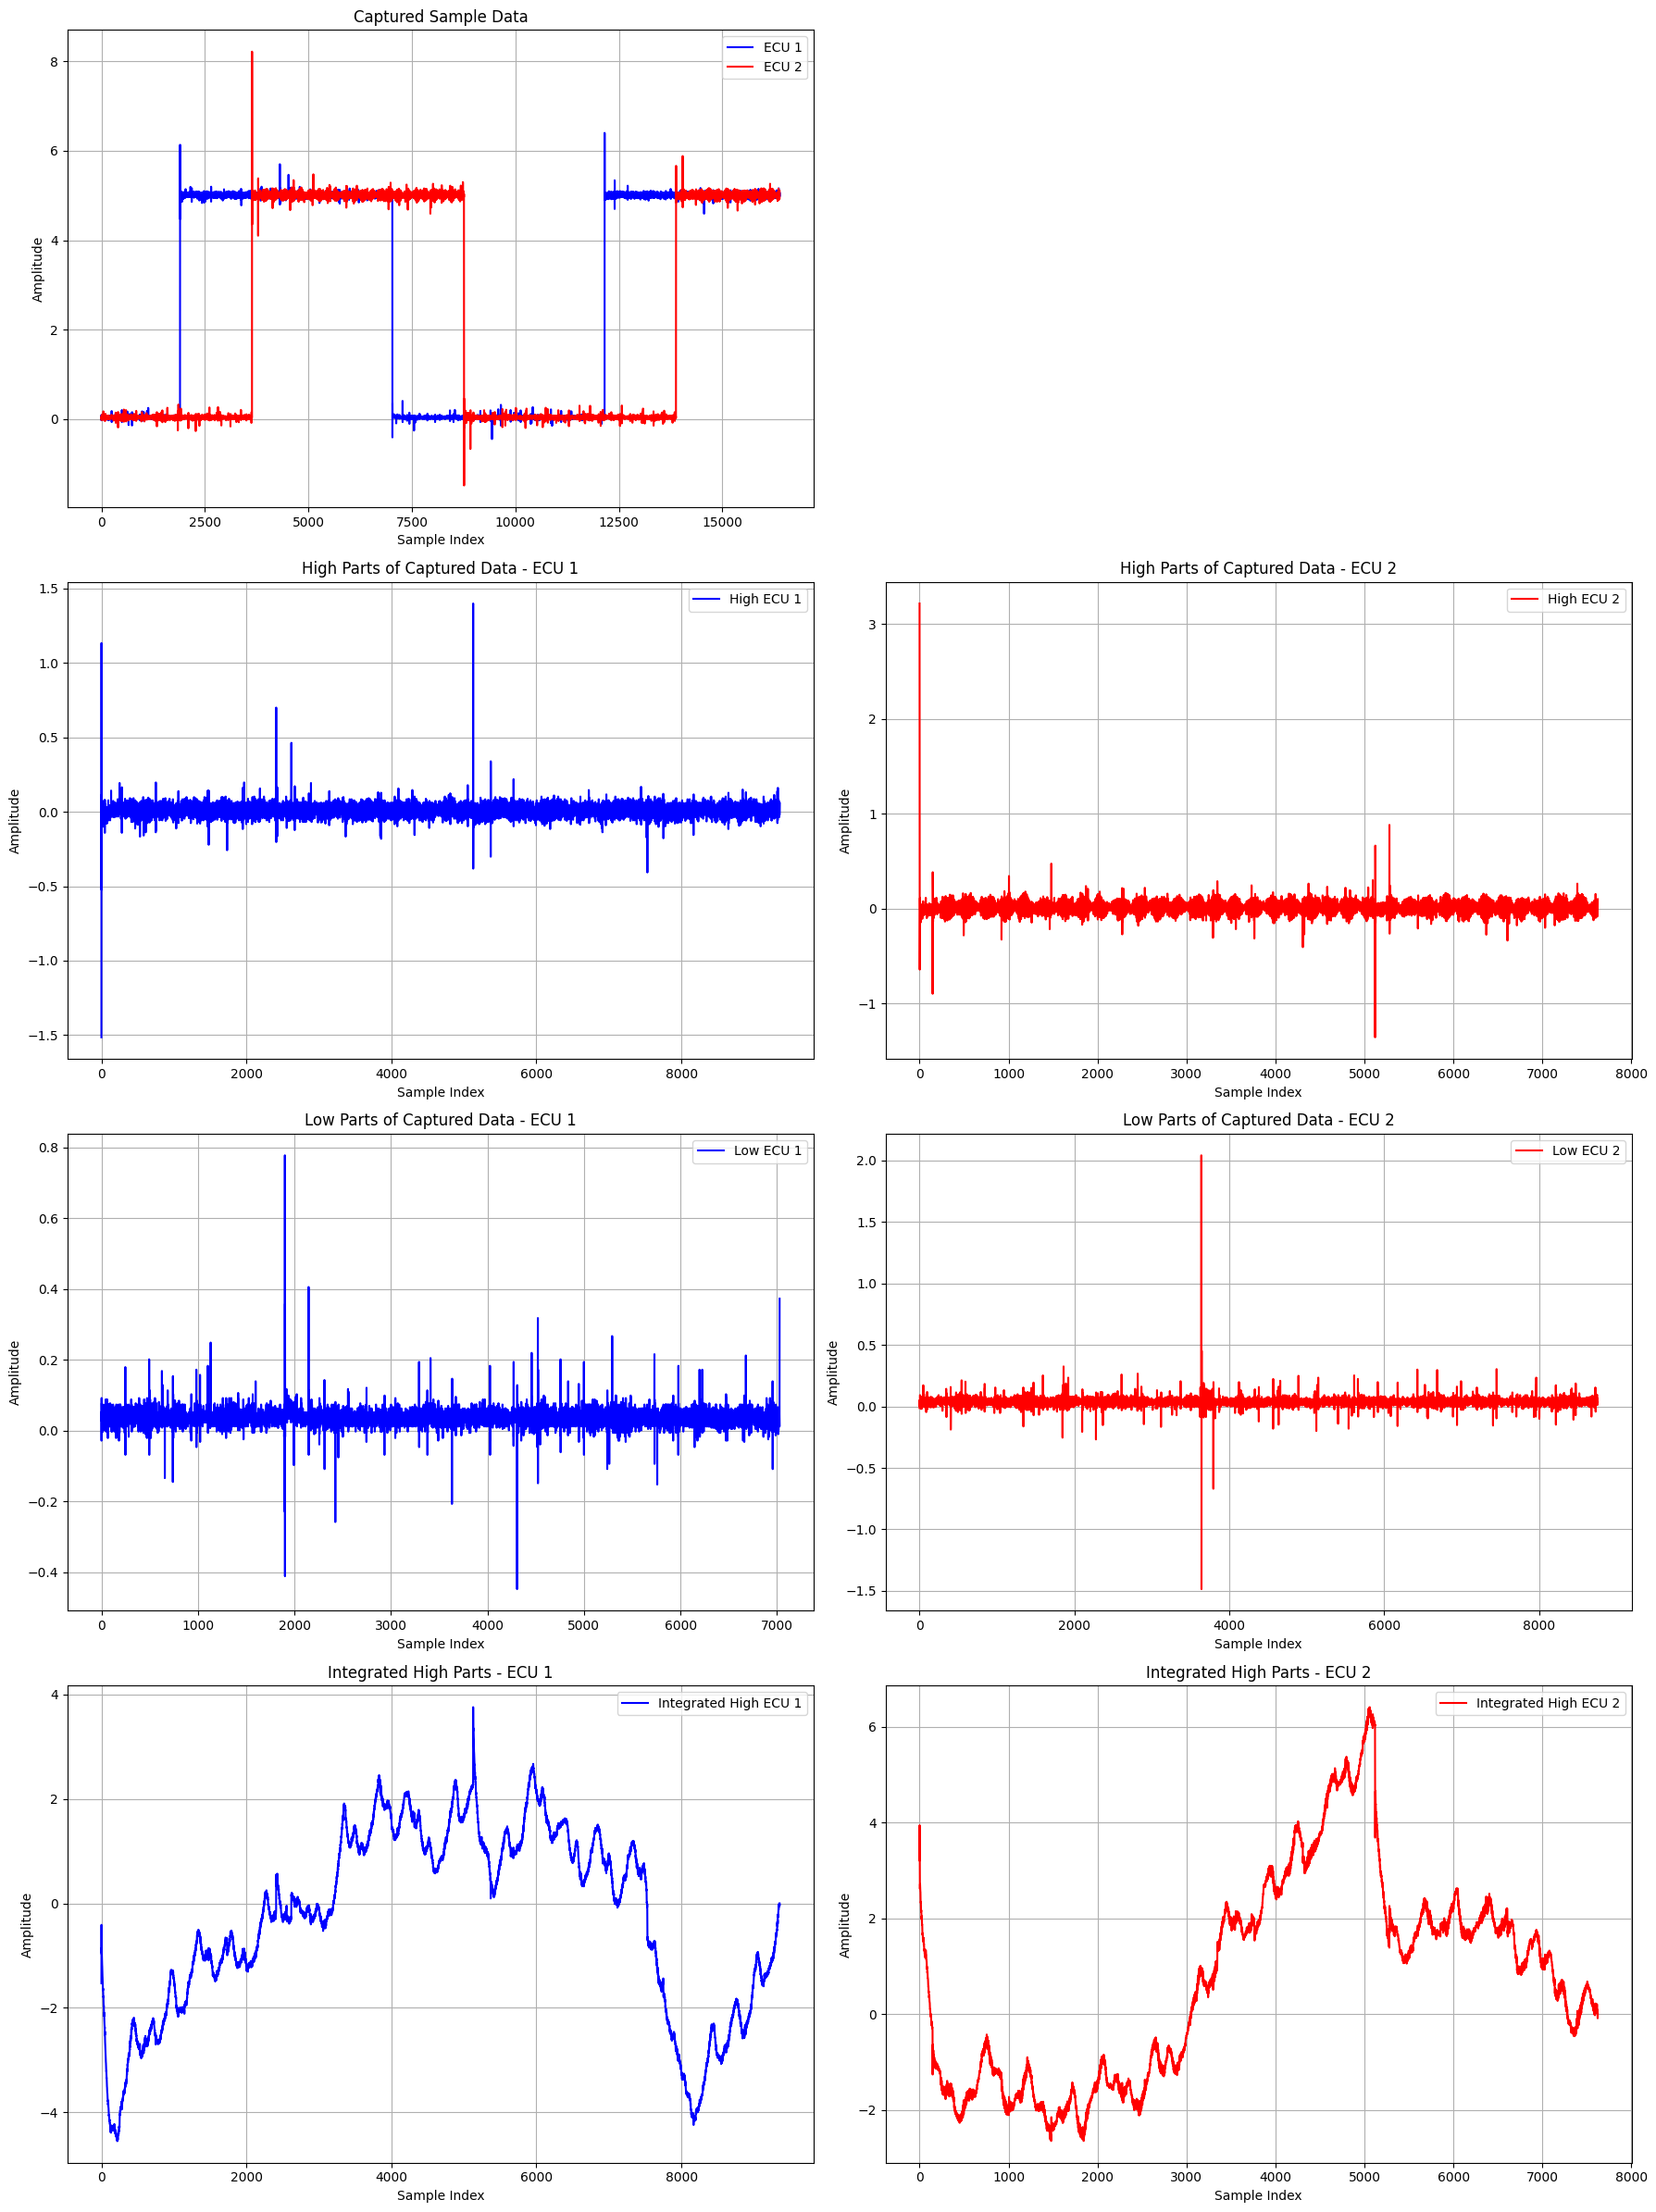

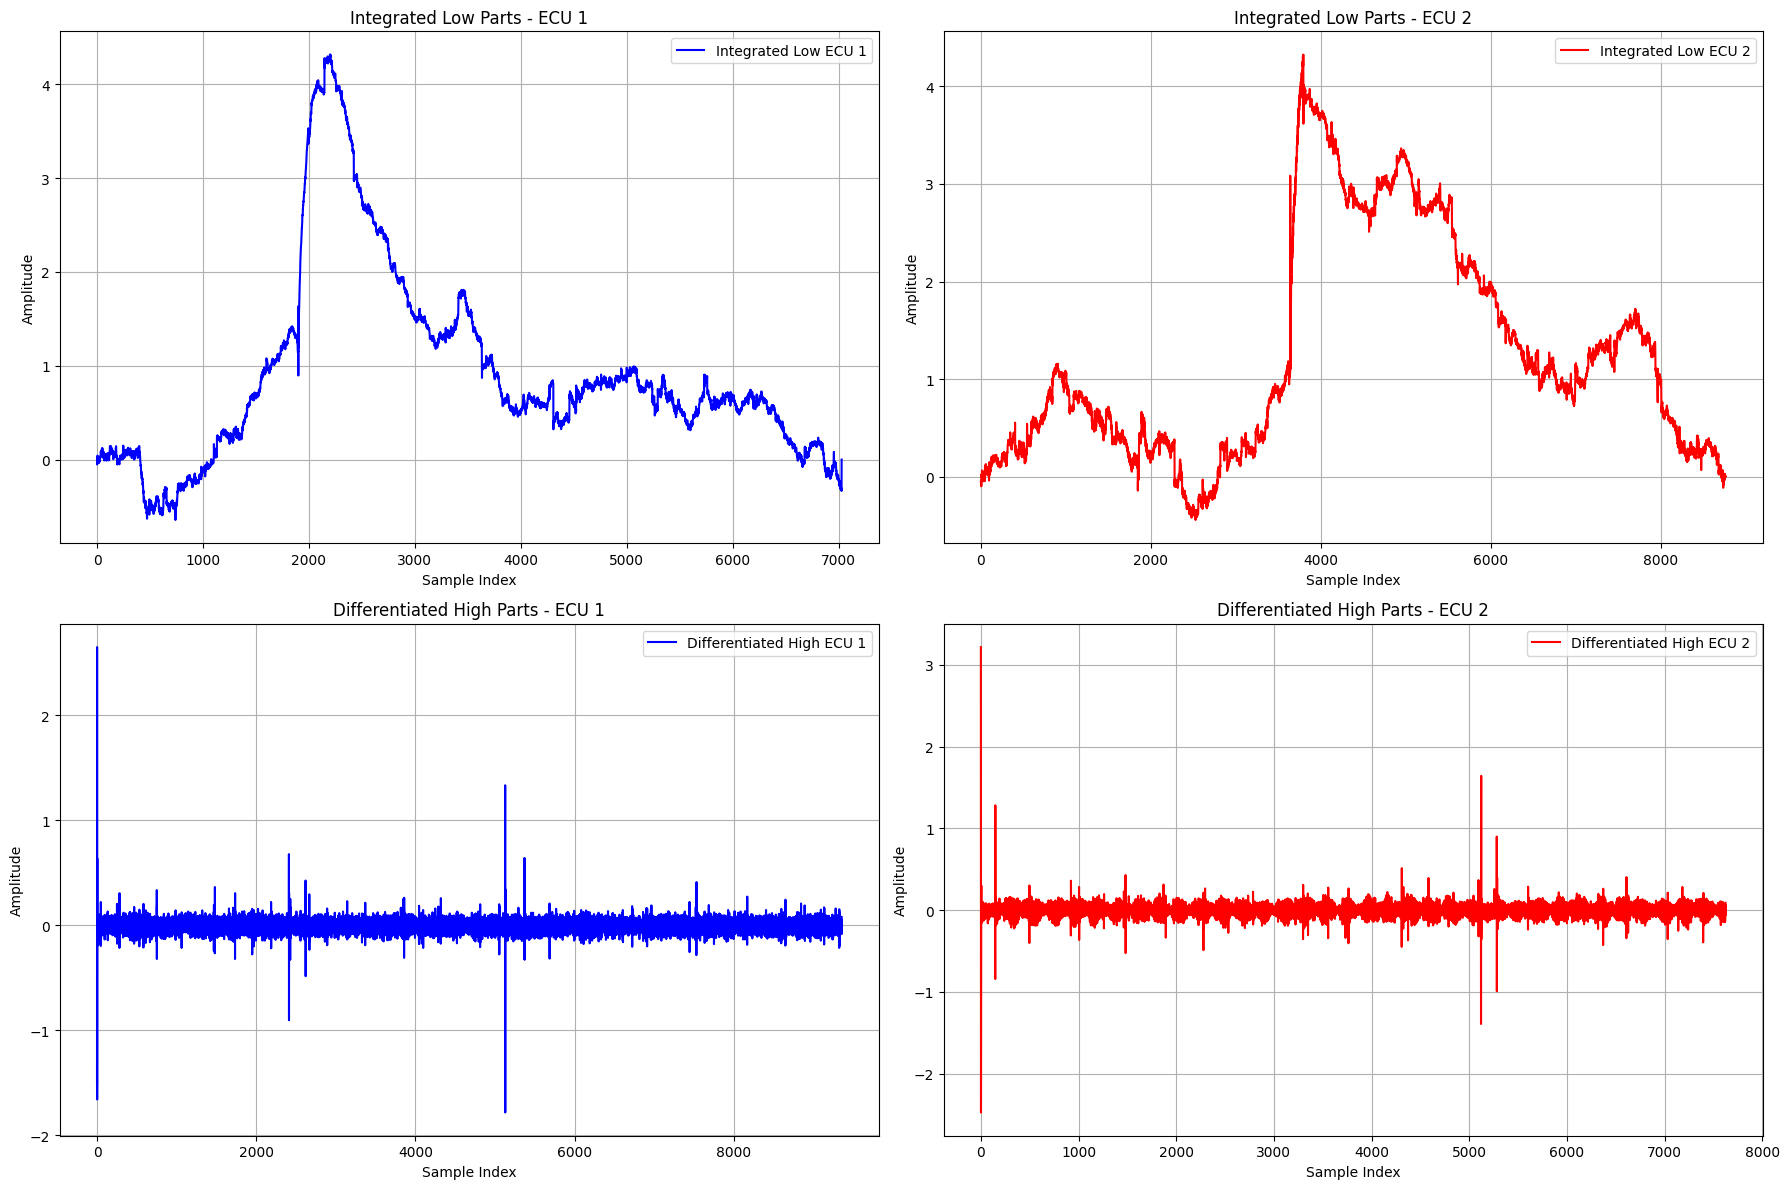

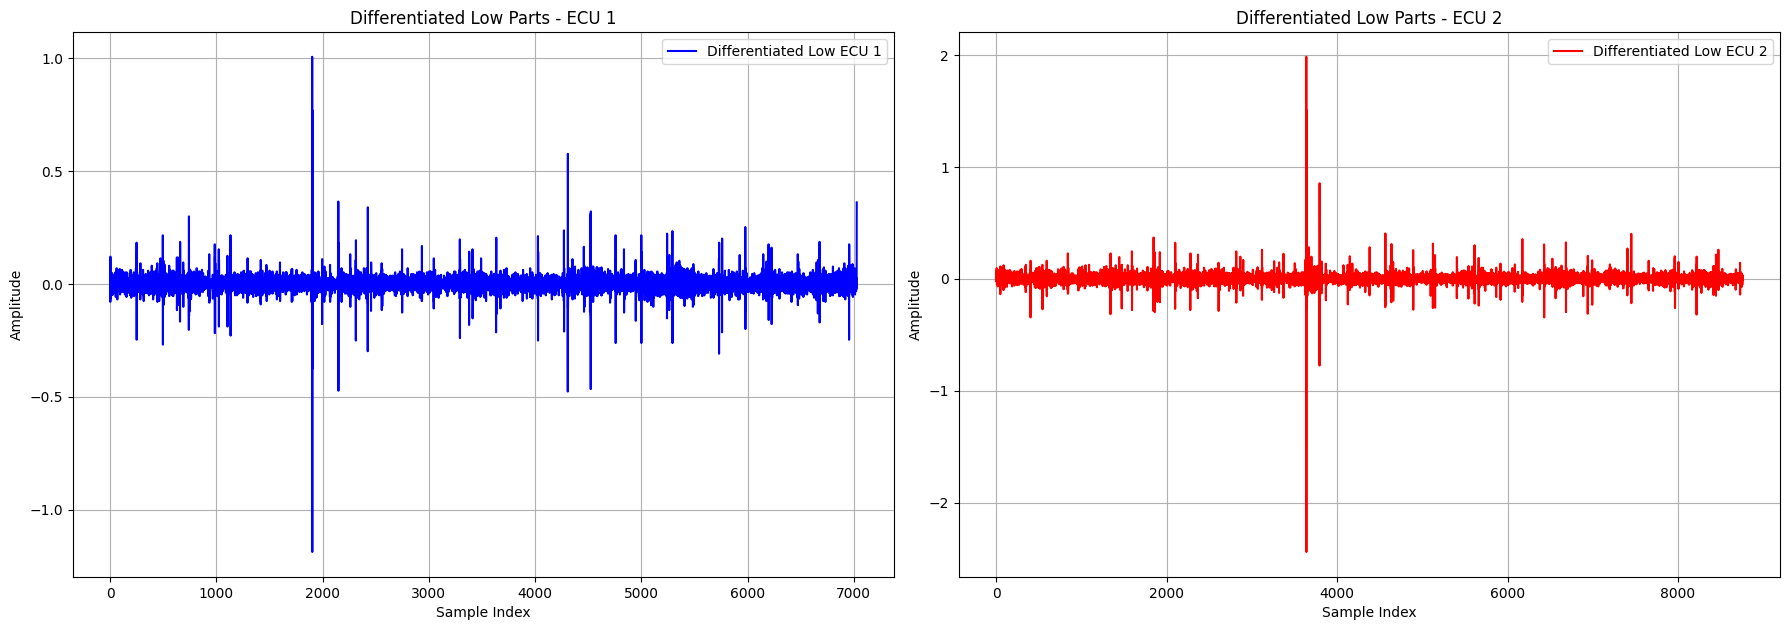

In [5]:
import sys
import numpy as np
from ctypes import *
from dwfconstants import *
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Configuration parameters
sample_count = 16384
frequency = 10000000  # Single frequency to capture data at

def open_device():
    # Load the correct library for the platform
    if sys.platform.startswith("win"):
        dwf = cdll.dwf
    elif sys.platform.startswith("darwin"):
        dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    else:
        dwf = cdll.LoadLibrary("libdwf.so")
    
    # Variables for the device
    hdwf = c_int()
    dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
    if hdwf.value == 0:
        szerr = create_string_buffer(512)
        dwf.FDwfGetLastErrorMsg(szerr)
        print("Failed to open device:", szerr.value.decode())
        sys.exit(1)
    return dwf, hdwf

def close_device(dwf, hdwf):
    dwf.FDwfDeviceCloseAll()

def capture_data(dwf, hdwf):
    # Pre-allocate an array for capturing samples
    rgdSamples = (c_double * sample_count)()

    # Set up the analog input channel
    dwf.FDwfAnalogInFrequencySet(hdwf, c_double(frequency))
    dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(sample_count))
    dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(-1), c_int(1))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(-1), c_double(30))
    dwf.FDwfAnalogInChannelFilterSet(hdwf, c_int(-1), c_int(0))  # Using 0 as filterDecimate value

    # Confirming the range setting
    range_set = c_double()
    dwf.FDwfAnalogInChannelRangeGet(hdwf, c_int(-1), byref(range_set))

    dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1))

    # Capture data until the acquisition is done
    sts = c_byte()
    while True:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        if sts.value == 2:  # Assuming 2 is the value for DwfStateDone
            break

    dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples, sample_count)
    return np.frombuffer(rgdSamples, dtype=np.double)

def separate_high_low(data, threshold=2.5):
    high_data = data[data > threshold] - 5
    low_data = data[data <= threshold]
    return high_data, low_data

def integrate(data):
    data_mean_subtracted = data - np.mean(data)
    return np.cumsum(data_mean_subtracted)

def differentiate(data):
    return np.diff(data, prepend=0)

def extract_features(data):
    # Time domain features
    time_domain_features = [
        np.max(data),                            # Max
        np.min(data),                            # Min
        np.mean(data),                           # Mean
        np.std(data),                            # Standard Deviation
        np.mean(np.abs(data - np.mean(data))),   # Mean deviation
        np.sqrt(np.mean(np.square(data))),       # Root mean square
        skew(data),                              # Skewness
        kurtosis(data)                           # Kurtosis
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)

    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),  # Centroid
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),                        # Entropy
        np.max(data) - np.min(data),                                                    # Spread
        skew(row_magnitude),                                                            # Skew
        np.mean(row_magnitude),                                                         # Average
        kurtosis(row_magnitude),                                                        # Kurtosis
        np.mean(np.abs(np.diff(data))),                                                 # Irregularity
        np.var(row_magnitude)                                                           # Variance
    ]

    return time_domain_features + frequency_domain_features

# List to store captures
captures = []

# First capture (expected to be noise)
dwf, hdwf = open_device()
captures.append(capture_data(dwf, hdwf))
close_device(dwf, hdwf)

# Wait for user to press Enter
input("Press Enter to start the second capture...")

# Second capture (expected to have data)
dwf, hdwf = open_device()
captures.append(capture_data(dwf, hdwf))
close_device(dwf, hdwf)

# Separate high and low parts
high_low_captures = [separate_high_low(data) for data in captures]

# Integrate and differentiate high and low parts
integrated_high_low = [(integrate(hl[0]), integrate(hl[1])) for hl in high_low_captures]
differentiated_high_low = [(differentiate(hl[0]), differentiate(hl[1])) for hl in high_low_captures]

# Extract features
all_features = []
feature_names = []

# Labels for the features
labels = ["Original High", "Original Low", "Integrated High", "Integrated Low", "Differentiated High", "Differentiated Low"]

# Extract features for ECU 1
for label, data in [
    ("Original High", high_low_captures[0][0]),
    ("Original Low", high_low_captures[0][1]),
    ("Integrated High", integrated_high_low[0][0]),
    ("Integrated Low", integrated_high_low[0][1]),
    ("Differentiated High", differentiated_high_low[0][0]),
    ("Differentiated Low", differentiated_high_low[0][1])
]:
    features = extract_features(data)
    all_features.append(features)
    feature_names.extend([f"{label} {name}" for name in [
        "Max", "Min", "Mean", "Std Dev", "Mean Deviation", "RMS", "Skewness", "Kurtosis",
        "Centroid", "Entropy", "Spread", "Frequency Skew", "Frequency Average",
        "Frequency Kurtosis", "Irregularity", "Frequency Variance"
    ]])

# Extract features for ECU 2
for label, data in [
    ("Original High", high_low_captures[1][0]),
    ("Original Low", high_low_captures[1][1]),
    ("Integrated High", integrated_high_low[1][0]),
    ("Integrated Low", integrated_high_low[1][1]),
    ("Differentiated High", differentiated_high_low[1][0]),
    ("Differentiated Low", differentiated_high_low[1][1])
]:
    features = extract_features(data)
    all_features.append(features)

# Convert to NumPy array for easy tabulation
features_array = np.array(all_features).T

# Combine feature names and features
feature_names = np.array(feature_names).reshape(-1, 1)
features_ecu_1 = features_array[:, :6]
features_ecu_2 = features_array[:, 6:]

# Ensure dimensions match for concatenation
features_ecu_1 = features_ecu_1.reshape(-1, 1)
features_ecu_2 = features_ecu_2.reshape(-1, 1)

# Combine feature names and features into a table
table = np.hstack([feature_names, features_ecu_1, features_ecu_2])

# Print the table
print("Feature Names/ECUs | ECU 1 | ECU 2")
for row in table:
    print(" | ".join(map(str, row)))

# Plot the captured sample data in a 4x2 grid
plt.figure(figsize=(18, 24))

# Plot original data for both ECUs
plt.subplot(4, 2, 1)
plt.plot(captures[0], label='ECU 1', color='blue')
plt.plot(captures[1], label='ECU 2', color = 'red')
plt.title('Captured Sample Data')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot high parts of ECU 1
plt.subplot(4, 2, 3)
plt.plot(high_low_captures[0][0], label='High ECU 1', color='blue')
plt.title('High Parts of Captured Data - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot high parts of ECU 2
plt.subplot(4, 2, 4)
plt.plot(high_low_captures[1][0], label='High ECU 2', color='red')
plt.title('High Parts of Captured Data - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot low parts of ECU 1
plt.subplot(4, 2, 5)
plt.plot(high_low_captures[0][1], label='Low ECU 1', color='blue')
plt.title('Low Parts of Captured Data - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot low parts of ECU 2
plt.subplot(4, 2, 6)
plt.plot(high_low_captures[1][1], label='Low ECU 2', color='red')
plt.title('Low Parts of Captured Data - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot integrated high parts of ECU 1
plt.subplot(4, 2, 7)
plt.plot(integrated_high_low[0][0], label='Integrated High ECU 1', color='blue')
plt.title('Integrated High Parts - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot integrated high parts of ECU 2
plt.subplot(4, 2, 8)
plt.plot(integrated_high_low[1][0], label='Integrated High ECU 2', color='red')
plt.title('Integrated High Parts - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot integrated low parts of ECU 1 and ECU 2
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(integrated_high_low[0][1], label='Integrated Low ECU 1', color='blue')
plt.title('Integrated Low Parts - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(integrated_high_low[1][1], label='Integrated Low ECU 2', color='red')
plt.title('Integrated Low Parts - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot differentiated high parts of ECU 1
plt.subplot(2, 2, 3)
plt.plot(differentiated_high_low[0][0], label='Differentiated High ECU 1', color='blue')
plt.title('Differentiated High Parts - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot differentiated high parts of ECU 2
plt.subplot(2, 2, 4)
plt.plot(differentiated_high_low[1][0], label='Differentiated High ECU 2', color='red')
plt.title('Differentiated High Parts - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot differentiated low parts of ECU 1 and ECU 2
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(differentiated_high_low[0][1], label='Differentiated Low ECU 1', color='blue')
plt.title('Differentiated Low Parts - ECU 1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(differentiated_high_low[1][1], label='Differentiated Low ECU 2', color='red')
plt.title('Differentiated Low Parts - ECU 2')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
